<a href="https://colab.research.google.com/github/faikozcan/MLFraud/blob/main/MLFraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Data With  Request To GitHub And Read Columns From CSV

In [27]:
import pandas as pd
import requests
import io
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

url="https://raw.githubusercontent.com/faikozcan/MLFraud/main/dataFiles/Fraud_Data.csv"
s=requests.get(url).content
#,usecols=["user_id","device_id","source","browser","purchase_value","sex","age","class","ip_address"]
c=pd.read_csv(io.StringIO(s.decode('utf-8')),sep = ",")


Data Enrichment

In [2]:
c['day_diff_purchase_signup'] = (pd.to_datetime(c['purchase_time']) - pd.to_datetime(c['signup_time'])).dt.days
device_dict = dict(c.device_id.value_counts())
ip_dict = dict(c.ip_address.value_counts())
# assign that dict to a column
c['device_TranCount'] = [device_dict[d] for d in c.device_id]
c['ip_TranCount'] = [ip_dict[d] for d in c.ip_address]
c['is_first_day_tran']= np.where(c['day_diff_purchase_signup'].between(0,0), 1, 0)
c['age_0_20']= np.where(c['age'].between(0,20), 1, 0)
c['age_21_40']= np.where(c['age'].between(21,40), 1,0)
c['age_41_60']= np.where(c['age'].between(41,60), 1, 0)
c['age_61_100']= np.where(c['age'].between(61,100), 1, 0)

c['amount_0_20']= np.where(c['purchase_value'].between(0,20), 1, 0)
c['amount_21_40']= np.where(c['purchase_value'].between(21,40), 1,0)
c['amount_41_60']= np.where(c['purchase_value'].between(41,60), 1, 0)
c['amount_61_100']= np.where(c['purchase_value'].between(61,100), 1, 0)
c['amount_101_10000']= np.where(c['purchase_value']>100, 1, 0)
c.head(10)


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,day_diff_purchase_signup,device_TranCount,ip_TranCount,is_first_day_tran,age_0_20,age_21_40,age_41_60,age_61_100,amount_0_20,amount_21_40,amount_41_60,amount_61_100,amount_101_10000
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,52,1,1,0,0,1,0,0,0,1,0,0,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,0,1,1,1,0,0,1,0,1,0,0,0,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,0,12,12,1,0,0,1,0,1,0,0,0,0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,5,1,1,0,0,0,1,0,0,0,1,0,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,50,1,1,0,0,0,1,0,0,1,0,0,0
5,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0,49,1,1,0,1,0,0,0,0,0,1,0,0
6,50116,2015-08-01 22:40:52,2015-08-27 03:37:57,11,IWKVZHJOCLPUR,Ads,Chrome,F,19,3.987484e+09,0,25,1,1,0,1,0,0,0,1,0,0,0,0
7,360585,2015-04-06 07:35:45,2015-05-25 17:21:14,27,HPUCUYLMJBYFW,Ads,Opera,M,34,1.692459e+09,0,49,1,1,0,0,1,0,0,0,1,0,0,0
8,159045,2015-04-21 23:38:34,2015-06-02 14:01:54,30,ILXYDOZIHOOHT,SEO,IE,F,43,3.719094e+09,0,41,1,1,0,0,0,1,0,0,1,0,0,0
9,182338,2015-01-25 17:49:49,2015-03-23 23:05:42,62,NRFFPPHZYFUVC,Ads,IE,M,31,3.416747e+08,0,57,1,1,0,0,1,0,0,0,0,0,1,0


One Hot Encoding For Categories

In [28]:
# use pd.concat to join the new columns with your original dataframe
c = pd.concat([c,pd.get_dummies(c['sex'], prefix='sex')],axis=1)
c = pd.concat([c,pd.get_dummies(c['browser'], prefix='browser')],axis=1)
c = pd.concat([c,pd.get_dummies(c['source'], prefix='source')],axis=1)




Drop Unnecessary Columns

In [29]:
c.drop(['purchase_time','user_id','signup_time','device_id','ip_address','sex','browser','source'],axis=1, inplace=True)

#c.drop(['age','purchase_value','day_diff_purchase_signup','user_id','purchase_time','signup_time','sex','browser','source','device_id','ip_address'],axis=1, inplace=True)
col = c.pop("class")
c.insert(len(c.columns), col.name, col)
c.head(10)


,purchase_value,age,sex_F,sex_M,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,source_Ads,source_Direct,source_SEO,class
0,34,39,0,1,1,0,0,0,0,0,0,1,0
1,16,53,1,0,1,0,0,0,0,1,0,0,0
2,15,53,0,1,0,0,0,1,0,0,0,1,1
3,44,41,0,1,0,0,0,0,1,0,0,1,0
4,39,45,0,1,0,0,0,0,1,1,0,0,0
5,42,18,0,1,1,0,0,0,0,1,0,0,0
6,11,19,1,0,1,0,0,0,0,1,0,0,0
7,27,34,0,1,0,0,0,1,0,1,0,0,0
8,30,43,1,0,0,0,1,0,0,0,0,1,0
9,62,31,0,1,0,0,1,0,0,1,0,0,0


Split Test And Training Data

In [30]:
y = c['class']
X = c.drop(['class'], axis = 1)
# Split the dataset to trainand test data
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=0)

print(X.shape)

(151112, 12)


Random Forest Algoritm

Feature: 0, Score: 0.39082
Feature: 1, Score: 0.32560
Feature: 2, Score: 0.02872
Feature: 3, Score: 0.02719
Feature: 4, Score: 0.03209
Feature: 5, Score: 0.01829
Feature: 6, Score: 0.03498
Feature: 7, Score: 0.02046
Feature: 8, Score: 0.01955
Feature: 9, Score: 0.02568
Feature: 10, Score: 0.05231
Feature: 11, Score: 0.02431


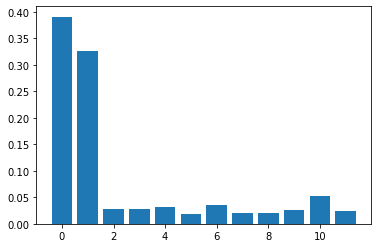

0.9075652496161787


In [31]:
parameters = {'bootstrap': True,
              'min_samples_leaf': 5,
              'n_estimators': 50, 
              'min_samples_split': 10,
              'max_features': 'sqrt',
              'max_depth': 6,
              'max_leaf_nodes': None}
modelRF = RandomForestClassifier(**parameters)
modelRF.fit(train_X, train_y)
predictions = modelRF.predict(test_X)
score = accuracy_score(test_y ,predictions)
# get importance
importance = modelRF.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()


print(score)


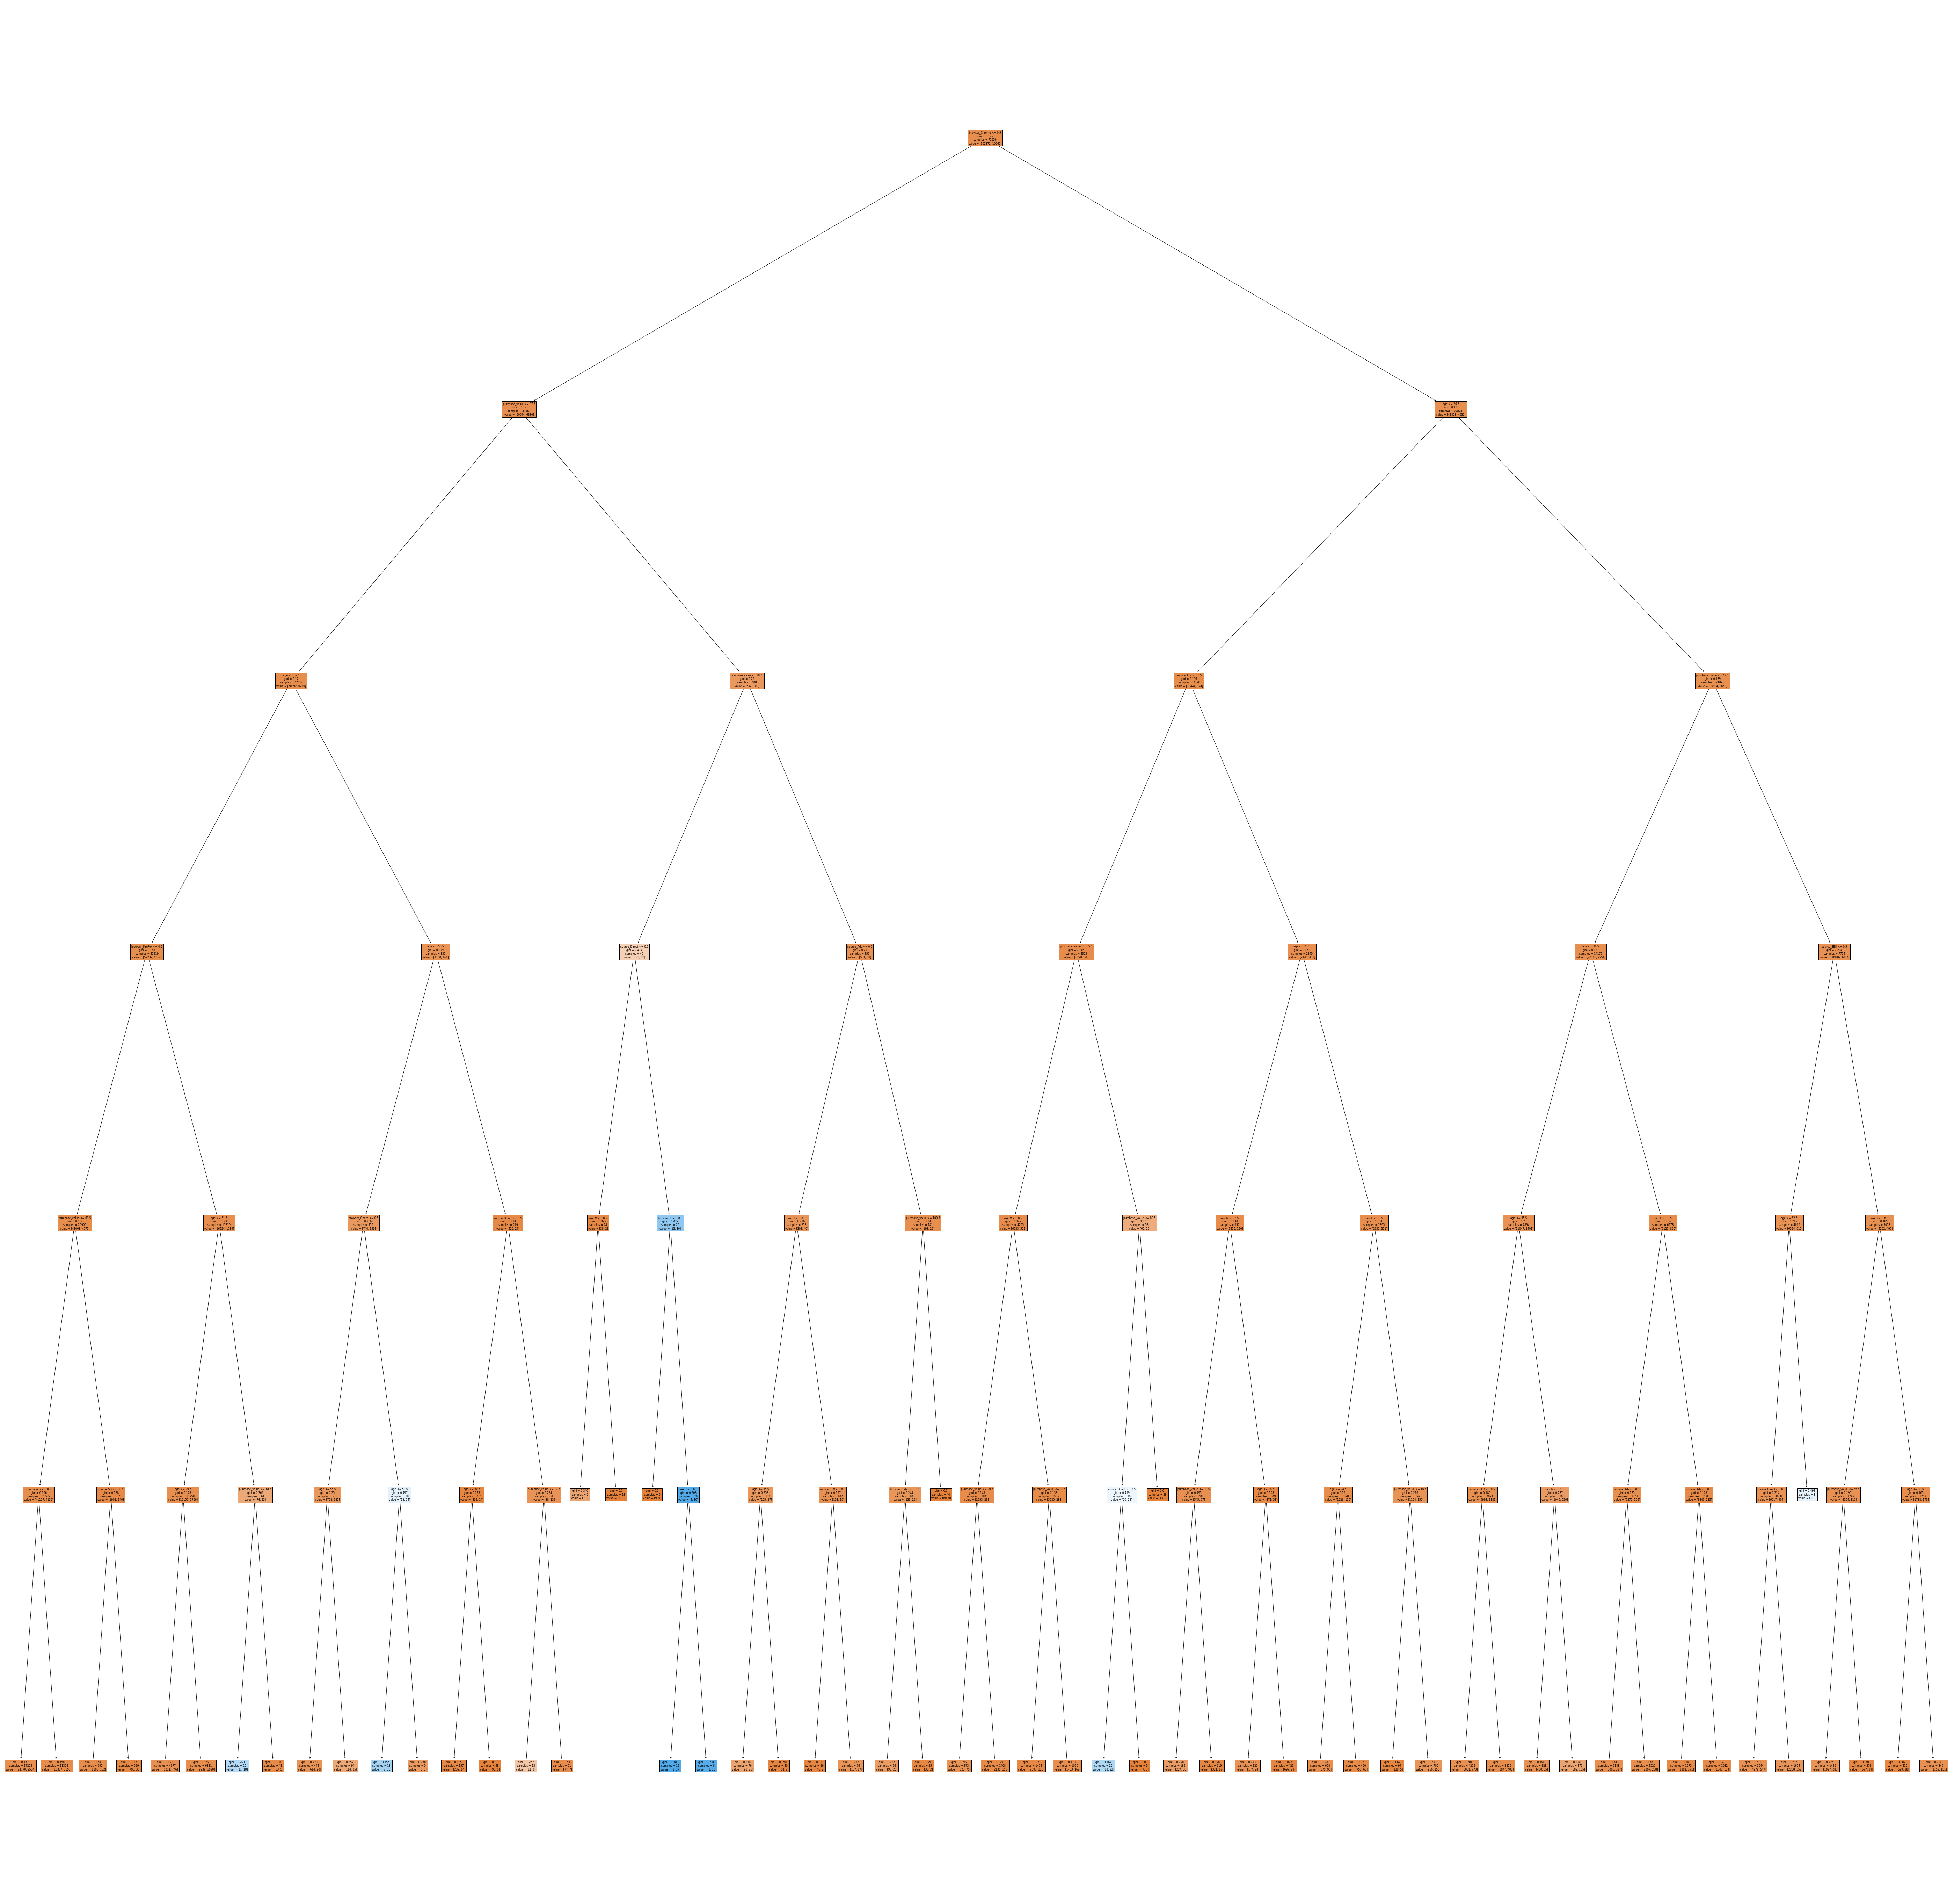

In [36]:
from sklearn import tree
from sklearn.tree import export_graphviz

estimator = modelRF.estimators_[10]

plt.figure(figsize=(100,100))
_ = tree.plot_tree(estimator, feature_names=X.columns, filled=True)
